In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

Using backend: pytorch



In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [52]:
def solvePDE(I, a, L, dt,F, T, lam, solveControl, kernel):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", nt)
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kernel, Nx-1, dx, dt*i)
    return u, x

def solveIntegralFD(X, nx, x, lam):
    k = np.zeros((len(x), len(x)))
    # First we calculate a at each timestep
    a = lam
    
    # FD LOOP
    k[1][1] = -(a[1] + a[0]) * dx / 4
    for i in range(1, len(x)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i]-dx/4.0*(a[i-1] + a[i])
        k[i+1][i] = k[i][i] - dx**2/2 * a[i]
        for j in range(1, i):
                k[i+1][j] = -k[i-1][j] + k[i][j+1] + k[i][j-1] + a[j]*(dx**2)*(k[i][j+1]+k[i][j-1])/2
    return k

def solveLambdaFunction(x, gamma):
    lam = np.zeros(nx)
    for idx, val in enumerate(x):
        lam[idx] = 5
    return lam

def solveControl(u, kernel, nx, dx):
    return sum(kernel[-1][0:nx+1]*u[0:nx+1])*dx

def openLoop(u, kernel, nx, dx):
    return 0

def solveKernel(x, y, lam):
    nx = len(x)
    ny = len(y)
    kernel = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            if i > j:
                root = math.sqrt(lam*(x[i]**2 - y[j]**2))
                kernel[i][j] = -lam*y[j] * scipy.special.i1(root)/root
            elif i == j:
                kernel[i][j] = -lam/2*x[i] 
    return kernel

def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1,int(nt)):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

def subSample(u, st):
    nt = int(len(u)/st)
    res = np.zeros((nt, len(u[0])))
    for i in range(nt):
        res[i] = u[int(i*st)]
    return res

In [4]:
def solveObserver(I, a, L, dt,F, T, lam, solveControl, kernel,uVal):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    print(dt)

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", nt)
        # Compute u at inner mesh point
        diff = (-3*uVal[i-1][-1]+4*uVal[i-1][-2]-uVal[i-1][-3])/(2*dx)- \
                (-3*u[i-1][-1]+4*u[i-1][-2]-u[i-1][-3])/(2*dx)
        u[i][1:nx] = u[i-1][1:nx] +  \
                F*(u[i-1][0:nx-1] - 2*u[i-1][1:nx] + u[i-1][2:nx+1]) + dt*lam[1:nx]*u[i-1][1:nx] - \
                dt*kernel[-1][1:nx]*diff
#         for j in range(1, nx):
#             u[i][j] = u[i-1][j] +  \
#                 F*(u[i-1][j-1] - 2*u[i-1][j] + u[i-1][j+1]) + dt*lam[j]*u[i-1][j] - \
#                 dt*kernel[-1][j]*diff
            
        #print("u", u[i-1][-1], u[i-1][-2], u[i-1][-3])
        #print("uval", uVal[i-1][-1], uVal[i-1][-2], uVal[i-1][-3])
        #print("res", dt*kernel[-1][j]*(-3*u[i-1][-1]+4*u[i-1][-2]-u[i-1][-3])/(2*dx))
        #print("k", kernel[-1][j])
        #if i == 5:
        #   return u, u

        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kernel, Nx-1, dx, i*dt)
    return u, x

In [5]:
X = 1
dx = 0.005
nx = int(round(X/dx))
spatial = np.linspace(0, X, nx+1, dtype=np.float32)


T = 1.5
dt = 0.000001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

class BranchNet(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(1, 16, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16,32, 5, stride=2)
        self.fc1 = torch.nn.Linear(73728, 1028)
        self.fc2 = torch.nn.Linear(1028, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 1, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 2
m = (nx+1)**2

branch = BranchNet(nx+1)

model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
model.load_state_dict(torch.load("parabolicKernelSmallAmp"))
grids = []
grids.append(spatial)
grids.append(spatial)
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = torch.from_numpy(grid).cuda()



2.3365020751953125e-05
2.0503997802734375e-05


In [84]:
X = 1
dx = 0.005
nx = int(round(X/dx))
spatial = np.linspace(0, X, nx+1, dtype=np.float32)

T = 3
dt = 0.000001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

def solveControlSinWave(u, kernel, nx, dx, t):
    return 10* np.sin(math.pi*2*t) + 7*np.cos(16*t)

 
def solveControlCosWave(u, kernel, nx, dx, t):
    return 10* np.cos(math.pi*2*t) + 7*np.sin(16*t)

init_cond = np.zeros(nx+1)
lam = np.zeros(nx+1)
for j in range(nx+1):
    init_cond[j] = 10
    lam[j] = 20*math.cos(5*math.acos(spatial[j]))
    
k = solveIntegralFD(X, nx, spatial, lam)

u, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControlSinWave, k)


u2, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControlCosWave, k)

for j in range(nx+1):
    init_cond[j] = 1

# Prepare Tensor solution
xval = []
for j in range(len(lam)):
        xval.append(lam)
xval = np.array(xval, dtype=np.float32)
xval = torch.from_numpy(xval.reshape(1, (nx+1)**2)).cuda()
khat = model((xval, grid))
khat = khat.cpu().detach().numpy().reshape(nx+1, nx+1)

uObserved, _ = solveObserver(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControlSinWave, k, u)
uObservedk, _ = solveObserver(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControlSinWave, khat, u)

for j in range(nx+1):
    init_cond[j] = 20

uObserved2, _ = solveObserver(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControlCosWave, k, u2)

uObservedk2, _ = solveObserver(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControlCosWave, khat, u2)

i 300000 / 3000000
i 600000 / 3000000
i 900000 / 3000000
i 1200000 / 3000000
i 1500000 / 3000000
i 1800000 / 3000000
i 2100000 / 3000000
i 2400000 / 3000000
i 2700000 / 3000000
i 300000 / 3000000
i 600000 / 3000000
i 900000 / 3000000
i 1200000 / 3000000
i 1500000 / 3000000
i 1800000 / 3000000
i 2100000 / 3000000
i 2400000 / 3000000
i 2700000 / 3000000
1.0000003333334445e-06
i 300000 / 3000000
i 600000 / 3000000
i 900000 / 3000000
i 1200000 / 3000000
i 1500000 / 3000000
i 1800000 / 3000000
i 2100000 / 3000000
i 2400000 / 3000000
i 2700000 / 3000000
1.0000003333334445e-06
i 300000 / 3000000
i 600000 / 3000000
i 900000 / 3000000
i 1200000 / 3000000
i 1500000 / 3000000
i 1800000 / 3000000
i 2100000 / 3000000
i 2400000 / 3000000
i 2700000 / 3000000
1.0000003333334445e-06
i 300000 / 3000000
i 600000 / 3000000
i 900000 / 3000000
i 1200000 / 3000000
i 1500000 / 3000000
i 1800000 / 3000000
i 2100000 / 3000000
i 2400000 / 3000000
i 2700000 / 3000000
1.0000003333334445e-06
i 300000 / 3000000
i 60

In [85]:
us = subSample(u, 1000)
uobs = subSample(uObserved, 1000)
uobsk = subSample(uObservedk, 1000)
us2 = subSample(u2, 1000)
uobs2 = subSample(uObserved2, 1000)
uobsk2 = subSample(uObservedk2, 1000)

nt = len(us)
temporal = np.linspace(0, T, nt)
print(us.shape)

(3000, 201)


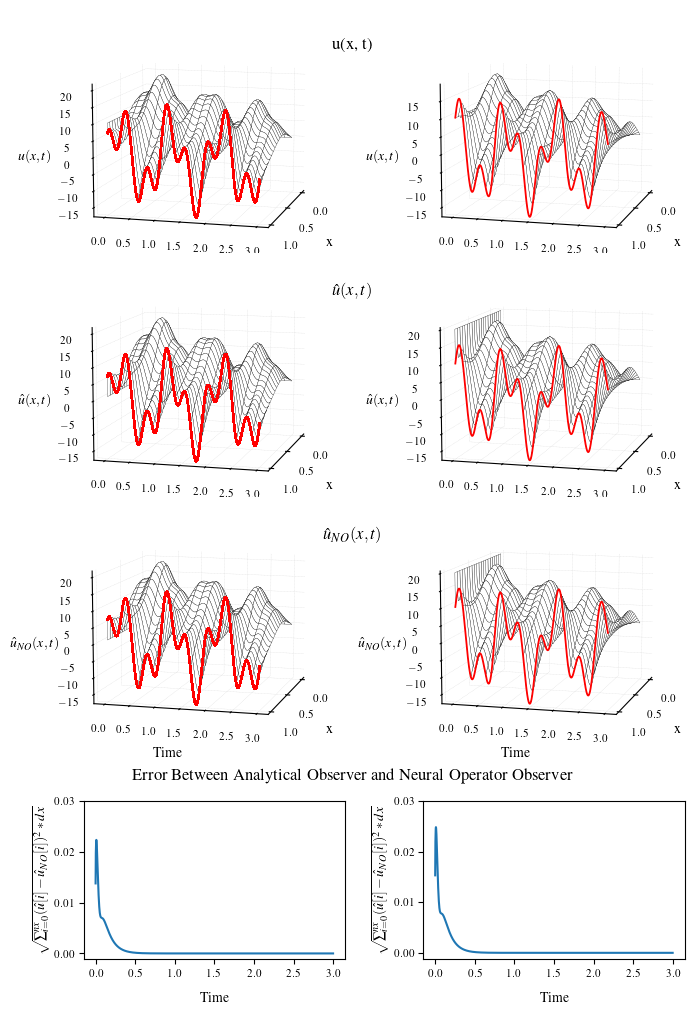

In [86]:
res = 10
fig = plt.figure(figsize=set_size(516, 0.99, (4, 2), height_add=1))
subfigs = fig.subfigures(nrows=4, ncols=1, hspace=0)

#### SOLUTION PLOT ####
subfig = subfigs[0]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"u(x, t)")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, us, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (us.transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, us2, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(nt))
vals = (us2.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$u(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

### OBSERVER #### 
subfig = subfigs[1]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"$\hat{u}(x, t)$")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uobs, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (uobs.transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$\hat{u}(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uobs2, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(nt))
vals = (uobs2.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

### OBSERVER #### 
subfig = subfigs[2]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"$\hat{u}_{NO}(x, t)$")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uobsk, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (uobsk.transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$\hat{u}_{NO}(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uobsk2, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(nt))
vals = (uobsk2.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}_{NO}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# ERROR
subfig = subfigs[3]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

zticks = np.linspace(-50, 50, 5)
subfig.suptitle(r"Error Between Analytical Observer and Neural Operator Observer")
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
ax[0].plot(temporal[:-1], getPDEl2(uobsk, uobs))
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("Time", labelpad=10)
ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (\hat{u}[i] - \hat{u}_{NO}[i])^2*dx}$")

ax[1].plot(temporal[:-1], getPDEl2(uobsk2, uobs2))
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[1].set_xlabel("Time", labelpad=10)
ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (\hat{u}[i] - \hat{u}_{NO}[i])^2*dx}$")
ax[1].set_yticks([0, 0.01, 0.02, 0.03])
ax[0].set_yticks([0, 0.01, 0.02, 0.03])


plt.savefig("observer.pdf", dpi=2000)

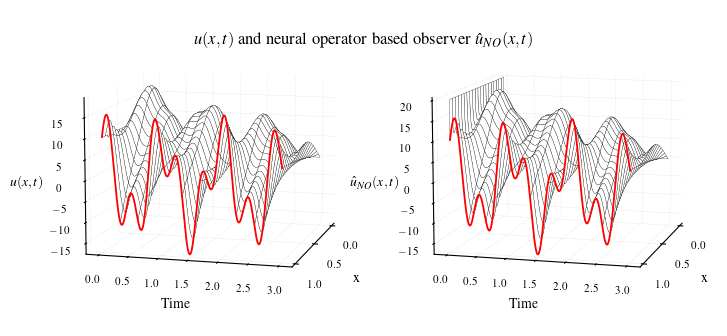

In [90]:
res = 10
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

#### SOLUTION PLOT ####
subfig = subfigs
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"$u(x, t)$ and neural operator based observer $\hat{u}_{NO}(x, t)$")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, us2, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (us2.transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uobsk2, edgecolor="black",lw=0.2, rstride=res*15, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(nt))
vals = (uobs2.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}_{NO}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("observer.pdf", dpi=2000)